# PyTorch CNN model

In this notebook, we build a convolutional neural network (CNN) classifier for the CIFAR-10 dataset using PyTorch's `nn.Sequential` module.

## Notebook set-up

### Imports

In [1]:
# Standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, 
    precision_recall_curve, average_precision_score
)

from sklearn.preprocessing import label_binarize
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Project imports
from functions.evaluation import evaluate_model
from functions.training import train_model

# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Hyperparameters

In [2]:
batch_size = 5000 # Training images come in 5 batches of 10,000
learning_rate = 1e-3
epochs = 50
print_every = 10 # Print training progress every n epochs

# CIFAR-10 class names in class order
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

## 1. Load and preprocess CIFAR-10 data

CIFAR-10 contains 32x32 color images (3 channels) across 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. We convert the images to grayscale for this demonstration.

### 1.1. Load datasets

In [3]:
# Make sure data directory exists
data_dir = Path('../data')
data_dir.mkdir(parents=True, exist_ok=True)

# Data preprocessing: convert to grayscale, tensor, and normalize
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load training and test datasets
train_dataset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transform
)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Number of classes: {len(class_names)}')

Training samples: 50000
Test samples: 10000
Image shape: torch.Size([1, 32, 32])
Number of classes: 10


### 1.2. Visualize sample images

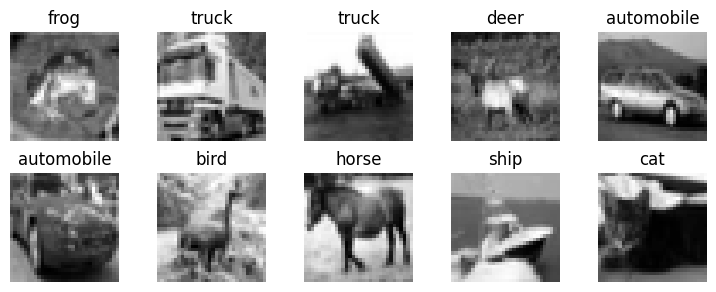

In [4]:
# Plot first 10 images from the training dataset
ncols = 5
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*1.5, nrows*1.5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Get image and label from dataset
    img, label = train_dataset[i]
    
    # Unnormalize and squeeze for plotting
    img = img * 0.5 + 0.5
    img = img.numpy().squeeze()
    ax.set_title(class_names[label])
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

### 1.3. Create training, validation and testing tensors

In [5]:
# Reshape and preload entire dataset to device for faster training
X_train_full = torch.stack([img for img, _ in train_dataset]).to(device)
y_train_full = torch.tensor([label for _, label in train_dataset]).to(device)

X_test = torch.stack([img for img, _ in test_dataset]).to(device)
y_test = torch.tensor([label for _, label in test_dataset]).to(device)

# Split training data into train and validation sets (80/20 split)
n_train = int(0.8 * len(X_train_full))
indices = torch.randperm(len(X_train_full))

X_train = X_train_full[indices[:n_train]]
y_train = y_train_full[indices[:n_train]]
X_val = X_train_full[indices[n_train:]]
y_val = y_train_full[indices[n_train:]]

print(f'X_train shape: {X_train.shape}, device: {X_train.device}')
print(f'y_train shape: {y_train.shape}, device: {y_train.device}')
print(f'X_val shape: {X_val.shape}, device: {X_val.device}')
print(f'y_val shape: {y_val.shape}, device: {y_val.device}')
print(f'X_test shape: {X_test.shape}, device: {X_test.device}')
print(f'y_test shape: {y_test.shape}, device: {y_test.device}')

X_train shape: torch.Size([40000, 1, 32, 32]), device: cuda:0
y_train shape: torch.Size([40000]), device: cuda:0
X_val shape: torch.Size([10000, 1, 32, 32]), device: cuda:0
y_val shape: torch.Size([10000]), device: cuda:0
X_test shape: torch.Size([10000, 1, 32, 32]), device: cuda:0
y_test shape: torch.Size([10000]), device: cuda:0


### 1.4. Create `DataLoader()` objects

In [6]:
# Create TensorDatasets
train_tensor_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_tensor_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_tensor_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(
    train_tensor_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_tensor_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_tensor_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f'Training batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

Training batches: 8
Validation batches: 2
Test batches: 2


## 2. Build CNN classifier with nn.Sequential

We build a convolutional neural network using `nn.Sequential`. The CNN uses convolutional layers to extract spatial features from the 32x32x1 grayscale images before classification.

### 2.1. Define model architecture

In [7]:
# Input: 1 x 32 x 32 (grayscale)
num_classes = 10

model = nn.Sequential(
    # Conv block 1: 1 -> 32 channels, 32x32 -> 16x16
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),
    
    # Conv block 2: 32 -> 64 channels, 16x16 -> 8x8
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),
    
    # Conv block 3: 64 -> 128 channels, 8x8 -> 4x4
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),
    
    # Classifier
    nn.Flatten(),
    nn.Linear(128 * 4 * 4, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
).to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f'\nTotal parameters: {trainable_params}')

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.5, inplace=False)
  (16): Conv2d(64, 128, kernel_size=(3, 3), strid

### 2.2. Define loss function and optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 2.3. Train model

In [9]:
%%time

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    print_every=print_every
)

Epoch 1/50 - loss: 2.3981 - accuracy: 12.84% - val_loss: 2.3369 - val_accuracy: 9.89%
Epoch 10/50 - loss: 1.5815 - accuracy: 41.31% - val_loss: 2.2614 - val_accuracy: 29.35%
Epoch 20/50 - loss: 1.2325 - accuracy: 56.11% - val_loss: 1.3151 - val_accuracy: 54.87%
Epoch 30/50 - loss: 1.0433 - accuracy: 63.34% - val_loss: 0.9780 - val_accuracy: 66.09%
Epoch 40/50 - loss: 0.9468 - accuracy: 67.21% - val_loss: 0.7973 - val_accuracy: 71.92%
Epoch 50/50 - loss: 0.8681 - accuracy: 70.24% - val_loss: 0.8130 - val_accuracy: 72.47%

Training complete.
CPU times: user 3min 32s, sys: 246 ms, total: 3min 32s
Wall time: 3min 30s


### 2.5. Learning curves

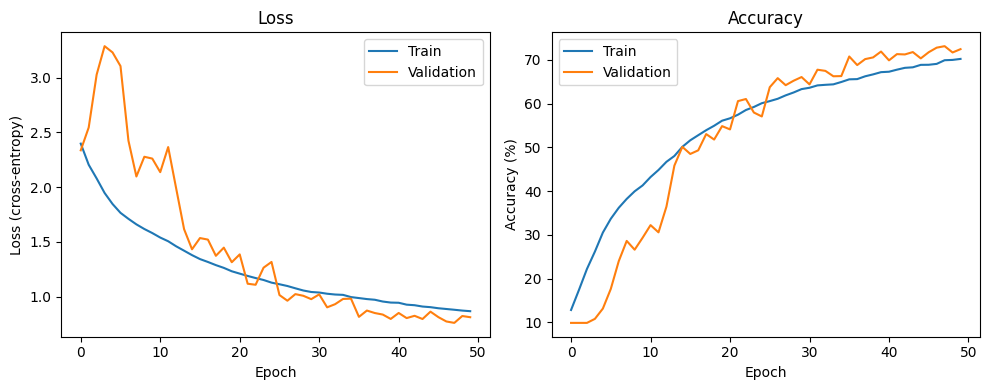

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Loss')
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (cross-entropy)')
axes[0].legend(loc='best')

axes[1].set_title('Accuracy')
axes[1].plot(history['train_accuracy'], label='Train')
axes[1].plot(history['val_accuracy'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

## 3. Evaluate model on test set

### 3.1. Calculate test accuracy

In [11]:
test_accuracy, predictions, true_labels = evaluate_model(model, test_loader)
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 72.17%


### 3.2. Per-class accuracy

In [12]:
# Calculate per-class accuracy
class_correct = {name: 0 for name in class_names}
class_total = {name: 0 for name in class_names}

for pred, true in zip(predictions, true_labels):

    class_name = class_names[true]
    class_total[class_name] += 1

    if pred == true:
        class_correct[class_name] += 1

print('Per-class accuracy:')
print('-' * 30)

for name in class_names:
    acc = 100 * class_correct[name] / class_total[name]
    print(f'{name:12s}: {acc:.2f}%')

Per-class accuracy:
------------------------------
airplane    : 63.10%
automobile  : 86.90%
bird        : 47.90%
cat         : 52.80%
deer        : 71.70%
dog         : 76.90%
frog        : 88.60%
horse       : 68.10%
ship        : 82.60%
truck       : 83.10%


### 3.4. Confusion matrix

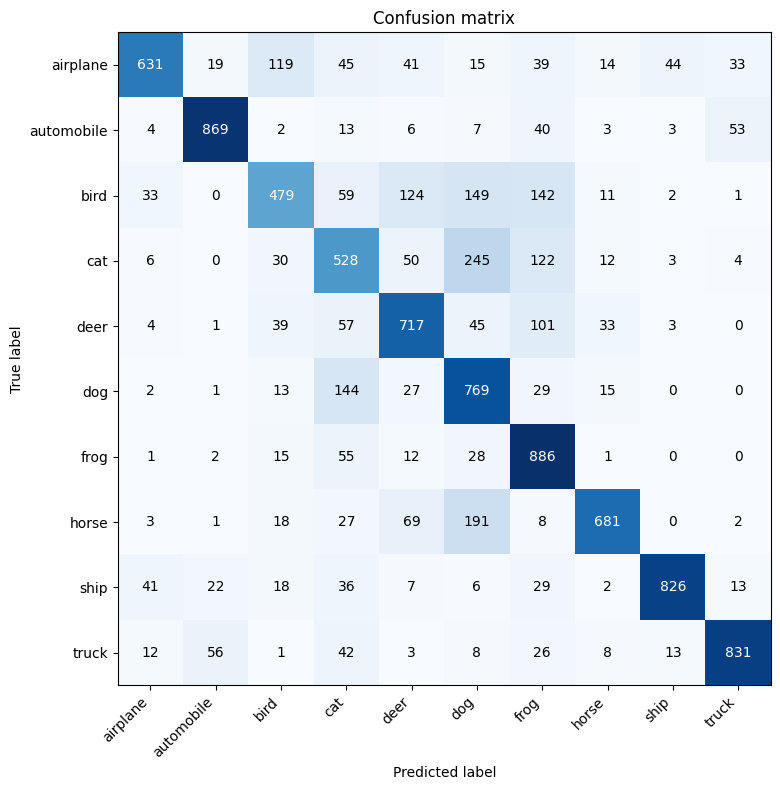

In [13]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

fig, ax = plt.subplots(figsize=(8, 8))

ax.set_title('Confusion matrix')
im = ax.imshow(cm, cmap='Blues')

# Add labels
ax.set_xticks(range(len(class_names)))
ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Add text annotations
for i in range(len(class_names)):

    for j in range(len(class_names)):
        color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        ax.text(j, i, str(cm[i, j]), ha='center', va='center', color=color)

plt.tight_layout()
plt.show()

### 3.5. Predicted class probability distributions

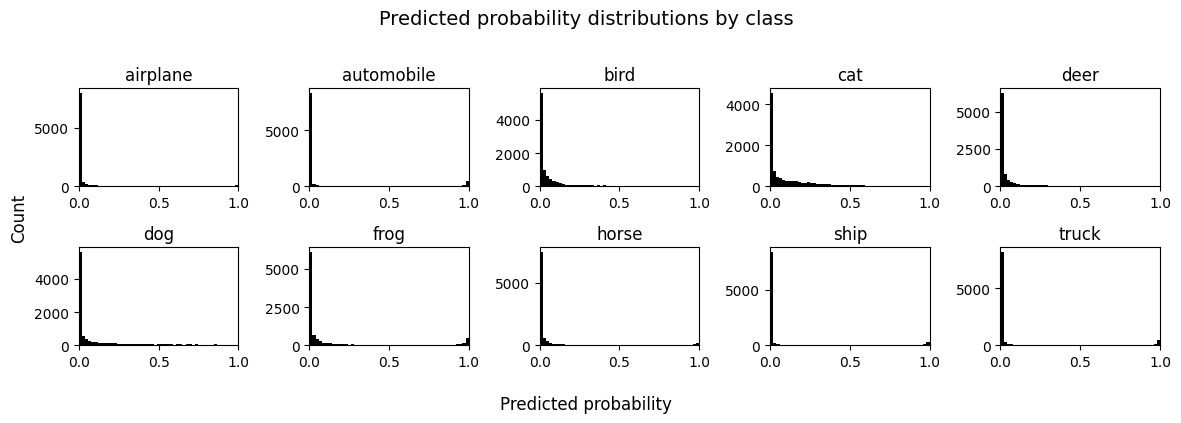

In [14]:
# Get predicted probabilities for all test samples
model.eval()
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)

# Plot probability distributions for each class
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 4))

fig.suptitle('Predicted probability distributions by class', fontsize=14, y=1.02)
fig.supxlabel('Predicted probability', fontsize=12)
fig.supylabel('Count', fontsize=12)

axes = axes.flatten()

for i, (ax, class_name) in enumerate(zip(axes, class_names)):

    # Get probabilities for this class across all samples
    class_probs = all_probs[:, i]
    
    # Plot density using histogram with density normalization
    ax.hist(class_probs, bins=50, color='black')
    ax.set_title(class_name)
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

### 3.6. Evaluation curves

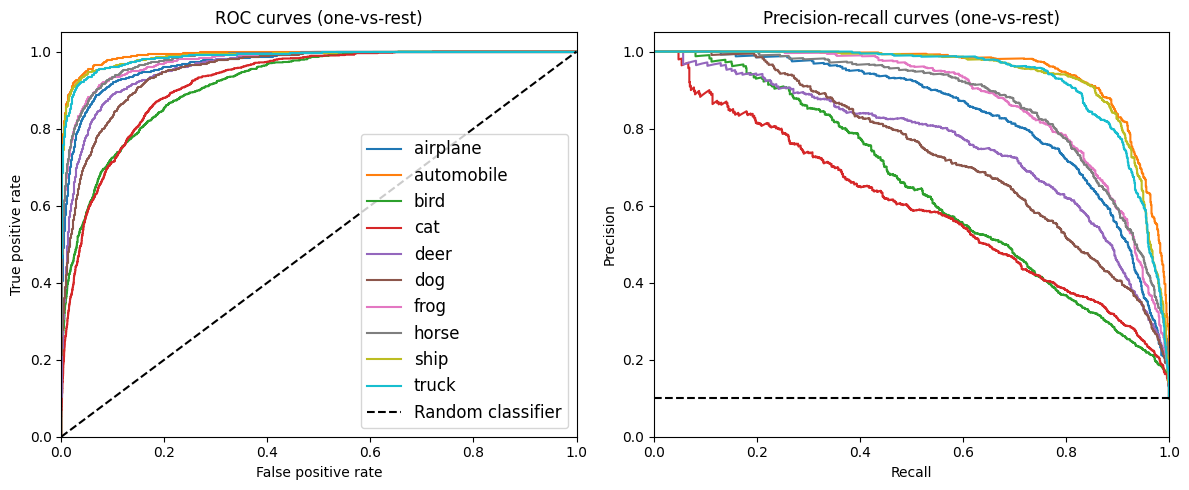

In [15]:
# Binarize true labels for one-vs-rest evaluation
y_test_bin = label_binarize(true_labels, classes=range(len(class_names)))

# Create figure with ROC and PR curves side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ROC curves for each class
ax1.set_title('ROC curves (one-vs-rest)')

for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, label=class_name)

ax1.plot([0, 1], [0, 1], 'k--', label='Random classifier')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.legend(loc='lower right', fontsize=12)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1.05])

# Plot Precision-Recall curves for each class
ax2.set_title('Precision-recall curves (one-vs-rest)')

for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], all_probs[:, i])
    ap = average_precision_score(y_test_bin[:, i], all_probs[:, i])
    ax2.plot(recall, precision)

# Random classifier baseline (horizontal line at class prevalence = 1/num_classes)
baseline = 1 / len(class_names)
ax2.axhline(y=baseline, color='k', linestyle='--')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()